In [1]:
import data_processing
import numpy as np
import matplotlib.pyplot as plt
import config

In [ ]:
print(config.EPOCHS)

In [3]:
X, y = data_processing.load_images('data/train')
print(X.shape)
print(y.shape)

(467, 105, 105)
(467,)


In [4]:
(X_train, y_train) = data_processing.make_pairs(X, y)

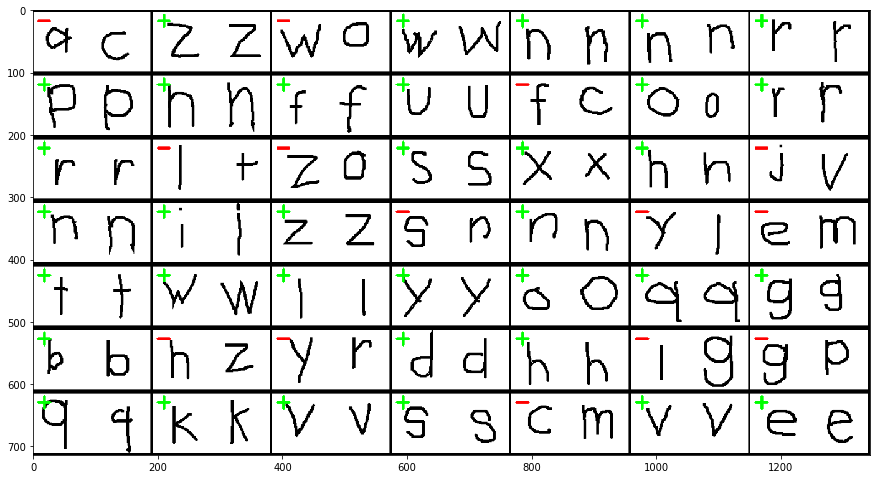

In [5]:
data_processing.pairs_montage(X_train, y_train)

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, Dense, Lambda, Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.regularizers import l2

In [8]:
def initialize_weights(shape, dtype=None):
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

In [9]:
def initialize_bias(shape, dtype=None):
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [10]:
def build_siamese_model(input_shape):

    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights, bias_initializer=initialize_bias))

    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)

    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])

    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1, activation='sigmoid')(L1_distance)

    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)

    # return the model
    return siamese_net

In [11]:
model = build_siamese_model(config.IMG_SHAPE)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 4096)         38947648    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 4096)         0           sequential[1][0]             

In [12]:
optimizer = Adam(lr=config.LEARNING_RATE)
model.compile(loss="binary_crossentropy", optimizer=optimizer)

In [13]:
trainX = np.expand_dims(X, axis=-1)
(X_train, y_train) = data_processing.make_pairs(trainX, y)

In [14]:
history = model.fit(
	[X_train[:, 0], X_train[:, 1]], y_train[:],
	validation_split=0.1,
	batch_size=config.BATCH_SIZE, 
	epochs=config.EPOCHS,
	verbose=0)

In [15]:
model.save(config.MODEL_PATH)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model/siamese_model/assets


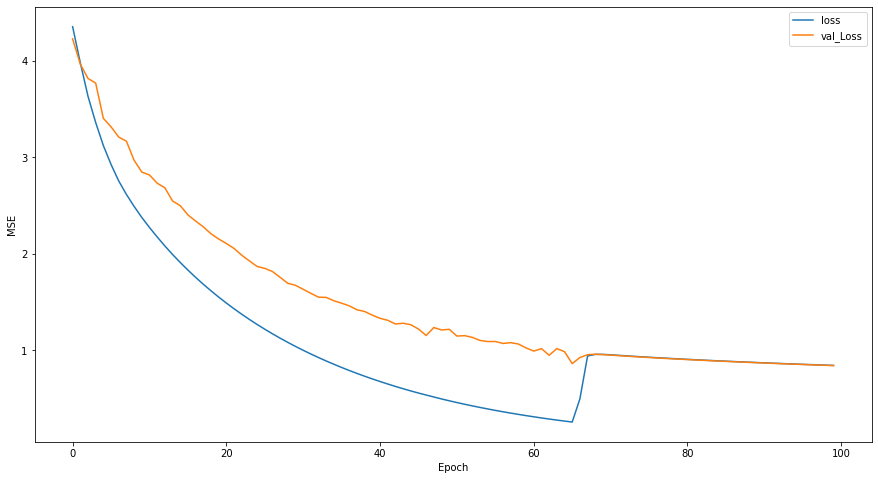

In [16]:
plt.figure(figsize=(15,8))

plt.xlabel('Epoch')
plt.ylabel('MSE')

plt.plot(model.history.history['loss'][:], label='loss')
plt.plot(model.history.history['val_loss'][:], label='val_Loss')
plt.legend()

In [17]:
tf.keras.backend.clear_session()

In [36]:
X_test, y_test = data_processing.load_images('data/test')
print(X_test.shape)
print(y_test.shape)

(52, 105, 105)
(52,)


0.50560844


(-0.5, 104.5, 104.5, -0.5)

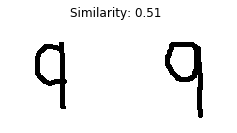

In [49]:
imageA = X_test[0]
imageB = X_test[1]

origA = imageA.copy()
origB = imageB.copy()

imageA = np.expand_dims(imageA, axis=-1)
imageB = np.expand_dims(imageB, axis=-1)

imageA = np.expand_dims(imageA, axis=0)
imageB = np.expand_dims(imageB, axis=0)

preds = model.predict([imageA, imageB])
proba = preds[0][0]

print(proba)

fig = plt.figure("Pair #{}".format(0 + 1), figsize=(4, 2))
plt.suptitle("Similarity: {:.2f}".format(proba))
# show first image
ax = fig.add_subplot(1, 2, 1)
plt.imshow(origA, cmap=plt.cm.gray)
plt.axis("off")
# show the second image
ax = fig.add_subplot(1, 2, 2)
plt.imshow(origB, cmap=plt.cm.gray)
plt.axis("off")